In [3]:
from datetime import datetime

import sys
sys.path.append(r'c:\users\severusbot\appdata\local\programs\python\python39\lib\site-packages')

import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np


## $\color{red}{\text{Get Data}}$

We will use python's Yahoo Finance package to get historical stock data. Following the paper's methods,
we will look at daily return data from 01/01/2001 - 04/01/2014.

In [4]:
prices = pd.DataFrame()

# For now, we are tracking these 5 positions
positions = ['VZ', 'AAPL', 'T', 'AMD', 'JPM']
startDate = datetime(2018, 1, 1)
endDate = datetime(2019, 1, 1)

for ticker in positions:
    temp = yf.Ticker(ticker).history(start = startDate, end = endDate)[['Close']]
    temp.rename(columns = {'Close': str(ticker)}, inplace = True)
    prices = pd.concat([prices, temp], axis = 1)

# We will use the 13 week T bill as the risk free rate
rf = 0.0178
    
# Convert to percent change
returns = prices.pct_change(1).iloc[1:, :]
returns.mean()

VZ      0.000464
AAPL   -0.000129
T      -0.000786
AMD     0.002863
JPM    -0.000215
dtype: float64

Text(0, 0.5, 'Daily Returns')

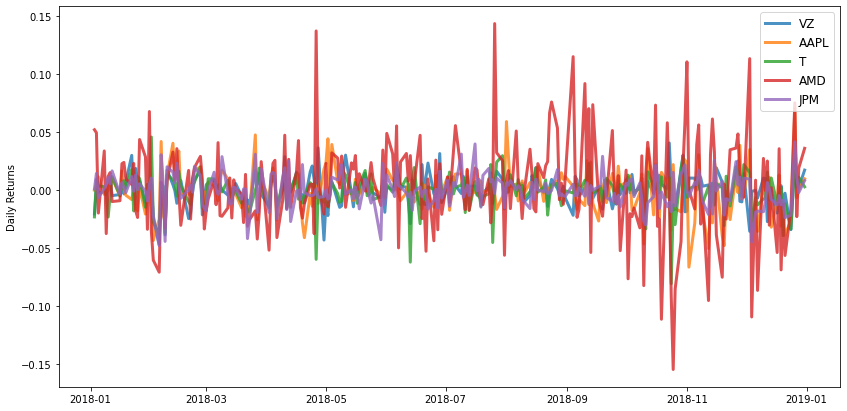

In [5]:
plt.figure(figsize = (14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw = 3, alpha = 0.8, label = c)

plt.legend(loc = 'upper right', fontsize = 12)
plt.ylabel('Daily Returns')

## $\color{red}{\text{Perform Reguralization on the Covariance Matrix}}$

We want to make sure our covariance matrix is nonsingular. Let's use regularization on the covariance matrix and the James Stein estimator for the mean vector.

The regularized covariance matrix is shown as 
$\hat{\Gamma} = \rho_1 \Gamma_S + \rho_2 I$

and the estimated mean
$\hat{\mu} = (1 - \rho)\mu_S + \rho \eta 1$

In [16]:
def regularization(matrix):
    
    cov = matrix.cov()
    
    # Compute sample covariance matrix
    sampleCov = matrix.values.T @ matrix.values / len(matrix.columns)
    sampleMean = matrix.mean()
    I = np.empty(shape = (len(cov), len(cov.columns)))
    I.fill(1)

    # Compute the estimates
    mu = np.dot(cov, I)
    alpha = np.linalg.norm(cov - mu * I)
    beta = np.linalg.norm(sampleCov - cov)
    delta = np.linalg.norm(sampleCov - mu * I)

    row1 = (beta**2)/(alpha**2 + beta**2)
    row2 = (alpha**2)/(delta**2)
    
    covEstimate = row1 * mu * I + row2 * sampleCov
    
    # Find the mean estimate
    meanEstimate = 0
    eta = max(sampleMean.sum() / sampleMean.size, 0.0004)
 
    denom = np.dot(np.dot(np.transpose((sampleMean - eta*np.ones(shape = (len(sampleMean),))).values.reshape((len(sampleMean), 1))), sampleCov),
                   np.dot(np.linalg.inv(covEstimate), (sampleMean - eta*np.ones(shape = (len(sampleMean),))).values.reshape((len(sampleMean), 1))))
    rightside = len(sampleMean - 2) / denom
    leftside = 1
    rho = min(leftside, rightside)
    meanEstimate = (1 - rho)*sampleMean + rho*eta*np.ones(shape = (len(sampleMean),))
    
    return covEstimate, meanEstimate

estCov, estMean = regularization(returns)
print(estCov)
print(estMean)

VZ      0.000439
AAPL    0.000439
T       0.000439
AMD     0.000439
JPM     0.000439
dtype: float64


## $\color{red}{\text{Construct Unpenalized Portfolio}}$

Before using the L1 and L2 penalizers, let's build the portfolio under Markowitz's original ideas. This will give us a good point of reference when comparing the results...

We will first compile a bunch of random portfolios and solve for their return and variance. We can select the best one and consider this to be the efficient portfolio.

MAXIMUM SHARPE PORTFOLIO
Annualized Return: 0.454
Annualized Volatility: 0.374
Positions      Weights
VZ		 0.403
AAPL		 0.029
T		 0.0
AMD		 0.565
JPM		 0.002


MINIMUM VARIANCE PORTFOLIO
Annualized Return: 0.022
Annualized Volatility: 0.166
Positions      Weights
VZ		 0.463
AAPL		 0.139
T		 0.104
AMD		 0.011
JPM		 0.283


Text(0, 0.5, 'Annualised Returns')

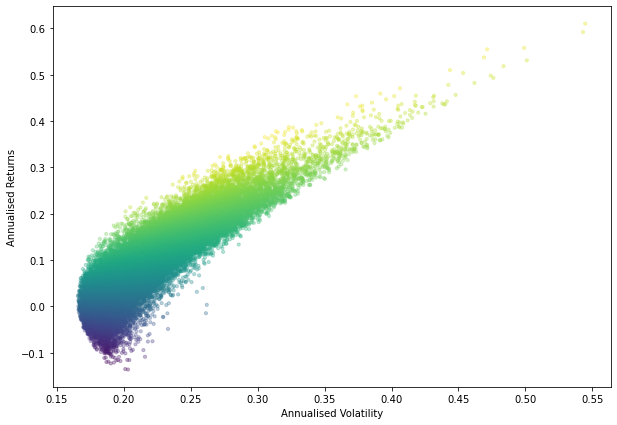

In [6]:
def random_portfolios(numPorts, mean_returns, cov, rf):
    
    output = np.zeros((3, numPorts))
    weight_lst = []
    for port in range(numPorts):
        
        weights = np.random.random(5)
        weights = weights / np.sum(weights)
        weight_lst.append(weights)
        
        returns = np.sum(mean_returns * weights) * 252
        std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
        
        output[0, port] = std
        output[1, port] = returns
        output[2, port] = (returns - rf) / std
    
    return output, weight_lst

numPorts = 25000
mean_returns = returns.mean()
cov = returns.cov()
results, weights = random_portfolios(numPorts, mean_returns, cov, rf)

# Find the portfolio with the largest sharpe
sharpe_idx = np.argmax(results[2])
sharpeWeights = weights[sharpe_idx].copy()

print('MAXIMUM SHARPE PORTFOLIO')
print(f'Annualized Return: {np.round(results[1, sharpe_idx], 3)}')
print(f'Annualized Volatility: {np.round(results[0, sharpe_idx], 3)}')

print('Positions      Weights')
for i in range(len(positions)):
    print(positions[i] + '\t\t ' + str(np.round(sharpeWeights[i], 3)))

# Find the portfolio with the minimum variance
std_idx = np.argmin(results[0])
stdWeights = weights[std_idx].copy()

print('\n')
print('MINIMUM VARIANCE PORTFOLIO')
print(f'Annualized Return: {np.round(results[1, std_idx], 3)}')
print(f'Annualized Volatility: {np.round(results[0, std_idx], 3)}')

print('Positions      Weights')
for i in range(len(positions)):
    print(positions[i] + '\t\t ' + str(np.round(stdWeights[i], 3)))
    
# Finally a plot of the portfolios
plt.figure(figsize = (10, 7))
plt.scatter(results[0,:], results[1,:], c = results[2,:], marker = 'o', s = 10, alpha = 0.3)
plt.xlabel('Annualised Volatility')
plt.ylabel('Annualised Returns')

## $\color{red}{\text{Construct Unpenalized Portfolio using Bootstrapping}}$

Bootstrapping is a type of crossvalidation that using randomized sampling to compute estimates. We can follow this process to find the optimal portfolio weights.

In [20]:
def bootstrapping(df, rf):
    
    numPorts = 1000
    sizeSample = int(len(df) / 3)
    
    sample = df.sample(n = sizeSample)
    mean_returns = sample.mean()
    cov = sample.cov()
    
    output = np.zeros((3, numPorts))
    weight_lst = []
    for port in range(numPorts):
        
        weights = np.random.random(5)
        weights = weights / np.sum(weights)
        weight_lst.append(weights)
        
        returns = np.sum(mean_returns * weights) * len(sample)
        std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(len(sample))
        
        output[0, port] = std
        output[1, port] = returns
        output[2, port] = (returns - rf) / std
        
    return output, weight_lst
    
iterations = 100
minVarPort_std = 1
maxShpPort_shp = -1

for it in range(iterations):
    
    results, weights = bootstrapping(returns.copy(), rf)
    
    sharpe_idx = np.argmax(results[2])
    sharpeWeights = weights[sharpe_idx].copy()

    std_idx = np.argmin(results[0])
    stdWeights = weights[std_idx].copy()
    
    if (results[0, std_idx] < minVarPort_std):
        minVarPort_std = results[0, std_idx]
        minVar_return = results[1, std_idx]
        minVarPort_w = weights[std_idx].copy()
    
    if (results[2, sharpe_idx] > maxShpPort_shp):
        maxShpPort_shp = results[2, sharpe_idx]
        maxShp_return = results[1, sharpe_idx]
        maxShp_std = results[0, sharpe_idx]
        maxShpPort_w = weights[sharpe_idx].copy()

print('MINIMUM VARIANCE PORTFOLIO')
print(f'Annualized Return: {np.round(minVar_return, 3)}')
print(f'Annualized Volatility: {np.round(minVarPort_std, 3)}')
print('Positions      Weights')
for i in range(len(positions)):
    print(positions[i] + '\t\t ' + str(np.round(minVarPort_w[i], 3)))

print('\n')
print('MAXIMUM SHARPE PORTFOLIO')
print(f'Sharpe Ratio: {np.round(maxShpPort, 3)}')
print(f'Annualized Return: {np.round(maxShp_return, 3)}')
print(f'Annualized Volatility: {np.round(maxShp_std, 3)}')
for i in range(len(positions)):
    print(positions[i] + '\t\t ' + str(np.round(maxShpPort_w[i], 3)))


MINIMUM VARIANCE PORTFOLIO
Annualized Return: -0.008
Annualized Volatility: 0.068
Positions      Weights
VZ		 0.498
AAPL		 0.137
T		 0.198
AMD		 0.011
JPM		 0.157


MAXIMUM SHARPE PORTFOLIO
Sharpe Ratio: 0.379
Annualized Return: 0.352
Annualized Volatility: 0.11
VZ		 0.537
AAPL		 0.038
T		 0.054
AMD		 0.237
JPM		 0.134
